In [47]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datei einlesen
netz = gpd.read_file("../../data/Rohdaten/FussVeloNetz_geojson/data/taz_mm.tbl_routennetz.json")

# Grundlegende Infos
print("Datentypen:")
print(netz.dtypes)

print("\nNullwerte pro Spalte:")
print(netz.isnull().sum().sort_values(ascending=False))

print("\nForm:", netz.shape)

print("\nErste 5 Zeilen:")
print(netz.head())

print("\nEindeutige Werte pro Spalte:")
print(netz.nunique().sort_values(ascending=False))

print("\nDoppelte Zeilen:", netz.duplicated().sum())
print("Doppelte Geometrien:", netz.geometry.duplicated().sum())

print("\nSpalten mit nur einem Wert:")
print(netz.columns[netz.nunique() <= 1])


Datentypen:
id1                    int32
velo                   int32
velostreifen          object
veloweg                int32
einbahn               object
fuss                   int32
name                  object
map_velo               int32
map_fuss               int32
se_anno_cad_data      object
objectid              object
geometry            geometry
dtype: object

Nullwerte pro Spalte:
se_anno_cad_data    40292
name                    8
velostreifen            1
id1                     0
velo                    0
veloweg                 0
einbahn                 0
fuss                    0
map_velo                0
map_fuss                0
objectid                0
geometry                0
dtype: int64

Form: (40292, 12)

Erste 5 Zeilen:
    id1  velo velostreifen  veloweg einbahn  fuss  \
0   642     0            0        0       0     1   
1   910     0            0        0       0     1   
2   808     1            0        0       0     0   
3  1139     0            0    

### 📝 Datenprüfung: Fuss- und Velowegnetz Zürich (`taz_mm.tbl_routennetz.json`)

Der Datensatz umfasst das **städtische Routennetz für den Fuss- und Veloverkehr** in Zürich und enthält insgesamt **40'292 Liniensegmente** mit zugehörigen Attributen und Geometrien.

**Datenstruktur:**
- Die Geometrie basiert auf `LINESTRING`-Objekten, was ideal für Routing-, Erreichbarkeits- oder Netzanalysen ist.
- Es sind 12 Spalten vorhanden, wobei 11 davon inhaltlich relevant sind (eine davon leer).
- Wichtige numerische Merkmale wie `velo`, `veloweg`, `map_velo`, `fuss`, `map_fuss` sind als `int32` kodiert und ermöglichen die gezielte Filterung nach Verkehrsart.
- Die Spalte `name` gibt (sofern vorhanden) den Namen der Strasse an.

**Nullwerte:**
- Die Spalte `se_anno_cad_data` ist **vollständig leer** (40'292 Nullwerte) → kann gelöscht werden.
- Weitere Spalten mit vereinzelten Nullwerten sind `name` (8x) und `velostreifen` (1x) → kein Handlungsbedarf.

**Doppelte Einträge:**
- Es existieren **22 doppelte Geometrien**, jedoch keine komplett doppelten Zeilen. Eine Bereinigung der doppelten Liniengeometrien ist optional, je nach Analyseziel.

**Eindeutige Werte:**
- Die Spalten `velo`, `veloweg`, `fuss` beinhalten binäre Werte (0 = nein, 1 = ja) → gut für Klassifizierung und Filterung.
- Weitere Attribute wie `velostreifen`, `einbahn`, `map_velo`, `map_fuss` weisen wenige diskrete Ausprägungen auf und eignen sich für Kategorisierung und visuelle Analyse.
- Die Strassennamen (`name`) enthalten 4'160 eindeutige Einträge – hilfreich für spätere Kontextanalysen oder Kartenbeschriftungen.

**Fazit:**
Der Datensatz bietet eine **sehr gute Grundlage für Netz- und Zugänglichkeitsanalysen**. Die Attribute erlauben gezielte Abfragen nach Fusswegen, Velowegen, Einbahnregelung und kartografischer Relevanz. Die einzige inhaltlich irrelevante Spalte ist `se_anno_cad_data` (vollständig leer). Der Datensatz kann direkt für **Spatial Joins**, **Distanzanalysen**, **Erreichbarkeits-Heatmaps** oder als Layer in QGIS und Python-Visualisierungen verwendet werden.


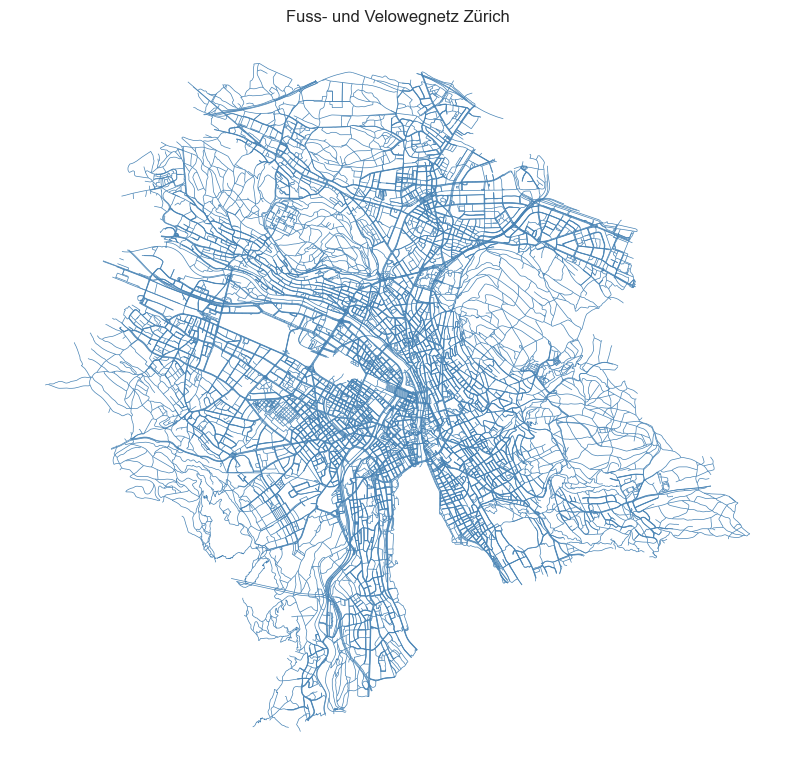

In [48]:
# Übersichtskarte des Routennetzes
netz.plot(figsize=(10, 10), linewidth=0.5, edgecolor='steelblue')
plt.title("Fuss- und Velowegnetz Zürich")
plt.axis("off")
plt.show()


In [55]:
# Nur relevante Spalten auswählen
netz_reduced = netz[[
    "fk_zaehler",
    "fuss",
    "name",
    "geometry"
]].copy()

# Spalte 'id1' zu 'id' umbenennen
netz_reduced.rename(columns={"id1": "id"}, inplace=True)

# Überblick über den neuen Datensatz
print("Neue Form:", netz_reduced.shape)
print("\nErste 5 Zeilen:")
print(netz_reduced.head())


KeyError: "['fk_zaehler'] not in index"

In [50]:
# Nur Zeilen behalten, bei denen fuss == 1 ist
netz_reduced = netz_reduced[netz_reduced["fuss"] == 1].copy()

# Danach die 'fuss'-Spalte komplett löschen
netz_reduced.drop(columns=["fuss"], inplace=True)

# Überblick über das Ergebnis
print("Neue Form nach Entfernen von fuss=0 und Löschen der Spalte:", netz_reduced.shape)
print("\nErste 5 Zeilen:")
print(netz_reduced.head())


Neue Form nach Entfernen von fuss=0 und Löschen der Spalte: (31131, 3)

Erste 5 Zeilen:
     id                             name  \
0   642                   Badenerstrasse   
1   910                   Zentralstrasse   
3  1139  Karl-Bürkli-Strasse Überquerung   
4  1118                 Zurlindenstrasse   
5  1402                    Zweierstrasse   

                                            geometry  
0    LINESTRING (8.51714 47.37541, 8.51741 47.37536)  
1    LINESTRING (8.51828 47.37269, 8.51815 47.37275)  
3    LINESTRING (8.51675 47.37692, 8.51683 47.37703)  
4    LINESTRING (8.51808 47.37191, 8.51804 47.37196)  
5  LINESTRING (8.51837 47.37012, 8.51783 47.36975...  


In [51]:
# Anzahl Segmente ohne Strassennamen prüfen
anzahl_fehlende_namen = netz_reduced["name"].isnull().sum()
print(f"Anzahl Segmente ohne Strassennamen (vor Löschung): {anzahl_fehlende_namen}")

# Zeilen löschen, bei denen 'name' fehlt (NaN)
netz_reduced = netz_reduced.dropna(subset=["name"]).copy()

# Kontrolle nach der Löschung
print("Neue Form nach dem Löschen:", netz_reduced.shape)

Anzahl Segmente ohne Strassennamen (vor Löschung): 4
Neue Form nach dem Löschen: (31127, 3)


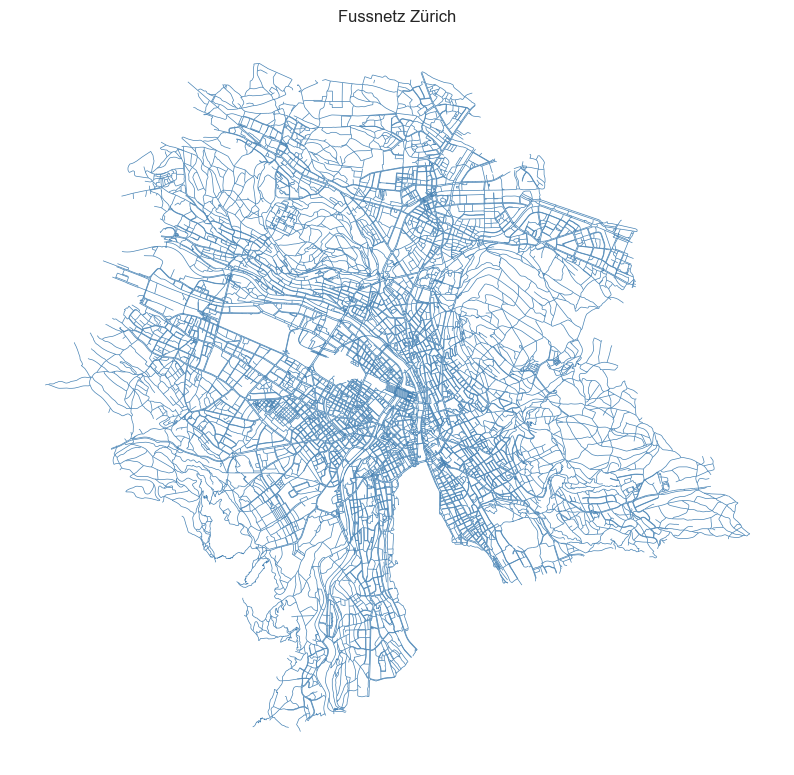

In [52]:
# Übersichtskarte des Routennetzes
netz_reduced.plot(figsize=(10, 10), linewidth=0.5, edgecolor='steelblue')
plt.title("Fussnetz Zürich")
plt.axis("off")
plt.show()


In [53]:
# Funktion zur Qualitätsprüfung eines DataFrames
def check_data_quality(df, name="DataFrame"):
    print(f"📋 Qualitätsprüfung für {name}\n")

    # Datentypen
    print("1. Datentypen:")
    print(df.dtypes)

    # Nullwerte
    print("\n2. Nullwerte pro Spalte:")
    print(df.isnull().sum().sort_values(ascending=False))

    # Form
    print("\n3. Form (Zeilen, Spalten):", df.shape)

    # Eindeutige Werte
    print("\n4. Eindeutige Werte pro Spalte:")
    print(df.nunique().sort_values(ascending=False))

    # Doppelte Zeilen
    print("\n5. Anzahl doppelter Zeilen:", df.duplicated().sum())

    # Vorschau
    print("\n6. Erste 5 Zeilen:")
    print(df.head())

    print("\n" + "-"*60 + "\n")

# Qualitätsprüfung für den bereinigten Fussweg-Datensatz
check_data_quality(netz_reduced, "netz_reduced (bereinigtes Fusswegnetz)")


📋 Qualitätsprüfung für netz_reduced (bereinigtes Fusswegnetz)

1. Datentypen:
id             int32
name          object
geometry    geometry
dtype: object

2. Nullwerte pro Spalte:
id          0
name        0
geometry    0
dtype: int64

3. Form (Zeilen, Spalten): (31127, 3)

4. Eindeutige Werte pro Spalte:
id          31127
geometry    31127
name         4042
dtype: int64

5. Anzahl doppelter Zeilen: 0

6. Erste 5 Zeilen:
     id                             name  \
0   642                   Badenerstrasse   
1   910                   Zentralstrasse   
3  1139  Karl-Bürkli-Strasse Überquerung   
4  1118                 Zurlindenstrasse   
5  1402                    Zweierstrasse   

                                            geometry  
0    LINESTRING (8.51714 47.37541, 8.51741 47.37536)  
1    LINESTRING (8.51828 47.37269, 8.51815 47.37275)  
3    LINESTRING (8.51675 47.37692, 8.51683 47.37703)  
4    LINESTRING (8.51808 47.37191, 8.51804 47.37196)  
5  LINESTRING (8.51837 47.37012, 8

## 🧠 Interpretation der Qualitätsprüfung: `netz_reduced` (bereinigtes Fusswegnetz)

Nach der gezielten Bereinigung des Datensatzes (`netz_reduced`) zeigt die abschliessende Qualitätsprüfung folgendes Ergebnis:

### 🔍 Datenstruktur:
- **Datentypen** sind korrekt: numerische ID (`int32`), Strassenname (`object`) und Geometrie (`geometry`).
- **Keine Nullwerte** in `id`, `name` oder `geometry`.
- **Form:** 31'127 Liniensegmente und 3 Spalten bleiben nach der Bereinigung übrig.
- **Eindeutige Werte:** 
  - Jeder `id`-Wert und jede `geometry` sind eindeutig.
  - Es gibt 4'042 verschiedene Strassennamen.

### 🛠️ Vorgehen und Sinnhaftigkeit:
- Durch das Löschen aller Segmente mit `fuss = 0` wurden nur **tatsächlich nutzbare Fusswegsegmente** behalten.
- Die anschliessende Entfernung der `fuss`-Spalte war sinnvoll, da sie danach nur noch den Wert `1` enthalten hätte und somit keine Information mehr trug.
- Ebenso wurden Segmente ohne Strassennamen entfernt, um die Datenqualität weiter zu verbessern (wichtig für spätere Zuordnungen und Analysen).
- Dadurch entstand ein **kompakter, übersichtlicher und vollständig nutzbarer Datensatz**, der ideal für weitere Netzwerkanalysen, Karten oder Erreichbarkeitsberechnungen ist.

### ✅ Fazit:
Der Datensatz ist vollständig, eindeutig, logisch aufgebaut und bereit für die nächste Verarbeitungs- oder Visualisierungsphase.


In [54]:
# Speichern des bereinigten Fussweg-Datensatzes als CSV
netz_reduced.to_csv(
    "../../data/Cleaned/Fusswegnetz.csv",
    index=False,
    encoding="utf-8"
)

print("Der bereinigte Fusswegnetz-Datensatz wurde erfolgreich als CSV gespeichert!")


Der bereinigte Fusswegnetz-Datensatz wurde erfolgreich als CSV gespeichert!
